In [0]:
try:
  import tflearn #try to import tflearn
except ImportError:
  !pip3 install -q tflearn #install tflearn first
  import tflearn #import it

In [0]:
import matplotlib.pyplot as plt #used for plotting images
import numpy as np #for math
import os, sys #to interact with filesystem
import tensorflow as tf #tensorflow during training
from tflearn.activations import relu #rectified linear activation function

#normalizes data
from tflearn.layers.normalization import batch_normalization as bn
from scipy.misc import imread, bytescale, imresize #image manipulation functions
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.estimator import regression #trainer for the network

#turns scalar label into vector where appropriate class is value 1 and others 0
from tflearn.data_utils import to_categorical

#makes new images from the ones we have by flipping them, rotating, etc.
from tflearn.data_augmentation import ImageAugmentation

#to visualize data space
from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
def install_tensorboard_dep():
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def montage(x, plot_shape=(15, 15), return_grid=False, cmap='viridis'):
  '''
  Takes in a 4-D tensor, x, of shape [NxHxWxC] and puts all of the images
  together in a single matrix to show as one image. If return_grid is True, 
  it will not show the matrix, but return it to be used in some other 
  operations.
  '''
  
  count = 0
  if not return_grid:
    scale = [0, 255]
  else:
    scale = [0, 1]
  
  
  if len(x.shape) == 4 and x.shape[-1] == 3:
    num, m, n, c = x.shape
  else:
    num, m, n = x.shape
    c = 1
    
  num = int(np.ceil(np.sqrt(num)))
  grid = np.zeros([num*m, num*n, c])
  
  if c == 1:
    grid = grid[..., 0]
  
  for i in range(num):
    for j in range(num):
      if count < x.shape[0]:
        if c == 1:
          grid[i*m:i*m+m, j*n:j*n+n] = bytescale(x[count, ...], 
                                                 low=scale[0], high=scale[1])
        else:
          grid[i*m:i*m+m, j*n:j*n+n, :] = bytescale(x[count, ...],
                                                    low=scale[0], high=scale[1])
        count += 1 
        
  if return_grid:
    return grid
  else:
    fig = plt.figure(figsize=plot_shape)
    a1 = fig.add_subplot(111)
    a1.set_xticks(np.arange(-0.5, num*n, n))
    a1.set_yticks(np.arange(-0.5, num*m, m))
    a1.set_yticklabels([])
    a1.set_xticklabels([])
    a1.imshow(grid, cmap=cmap)
    plt.show()

In [0]:
def start_tensorboard():
  '''starts tensorboard on colaboratory.'''
  LOG_DIR = '/tmp/tflearn_logs'
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
def viz_embedding(tensor, images, labels, shape):
  '''used to '''
  tb_dir = '/tmp/tflearn_logs'
  sess = tf.Session()
  sess.run(tensor.initializer)
  summary_writer = tf.summary.FileWriter(tb_dir)
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = tensor.name
  embedding.metadata_path = os.path.join(tb_dir, 'metadata.tsv')
  embedding.sprite.image_path = os.path.join(tb_dir, 'flowers.png') 
  embedding.sprite.single_image_dim.extend(shape)
  projector.visualize_embeddings(summary_writer, config)
  saver = tf.train.Saver([tensor])
  saver.save(sess, os.path.join(tb_dir, 'flowers.ckpt'), 1)
  
  image_grid = montage(images, return_grid=True)
  plt.imsave(os.path.join(tb_dir, 'flowers.png'), image_grid)
  
  with open(os.path.join(tb_dir, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(labels):
      f.write("%d\t%d\n" % (index,label))
  f.close()

In [55]:
responce = input('Do you want to train a network? (y/n) ') #ask a user if they want to train or load

#if input was Y, y, Yes, or yes, train a network
if responce in ['Y', 'y', 'Yes', 'yes']:
  Train = True
else:
  Train = False

Do you want to train a network? (y/n) y


In [56]:
print(Train)

True


In [0]:
#import dataset loader from tflearn
import tflearn.datasets.oxflower17 as oxflower17

#load the data in as X and the labels in as Y
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(150, 150))

In [58]:
print(X.shape, Y.shape) #print the shape of data and labels
print(Y[:10, ...]) #print first 10 label vectors

(1360, 150, 150, 3) (1360, 17)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


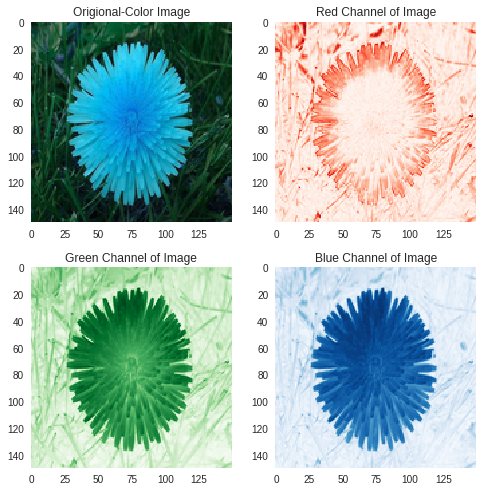

In [59]:
fig = plt.figure(figsize=(7,7)) #create a figure of size 7x7
a1 = fig.add_subplot(221) #add the first of four subplots in the figure
a2 = fig.add_subplot(222) #add the second of four subplots in the figure
a3 = fig.add_subplot(223) #add the third of four subplots
a4 = fig.add_subplot(224) #add the fourth of four subplots

x_show = X[0, :, :, ::-1]
a1.imshow(bytescale(X[0, :, :, ::-1])) #show the origional image
a2.imshow(x_show[..., 0], cmap='Reds') #show the first color channel of the image
a3.imshow(x_show[..., 1], cmap='Greens') #show the second color channel of the image
a4.imshow(x_show[..., 2], cmap='Blues') #show the third color channel of the image

#remove the grid and tick lines
a1.grid(False)
a2.grid(False)
a3.grid(False)
a4.grid(False)

#name each plot
a1.set_title('Origional-Color Image')
a2.set_title('Red Channel of Image')
a3.set_title('Green Channel of Image')
a4.set_title('Blue Channel of Image')

plt.tight_layout() #helps organize figure if there are many subplots

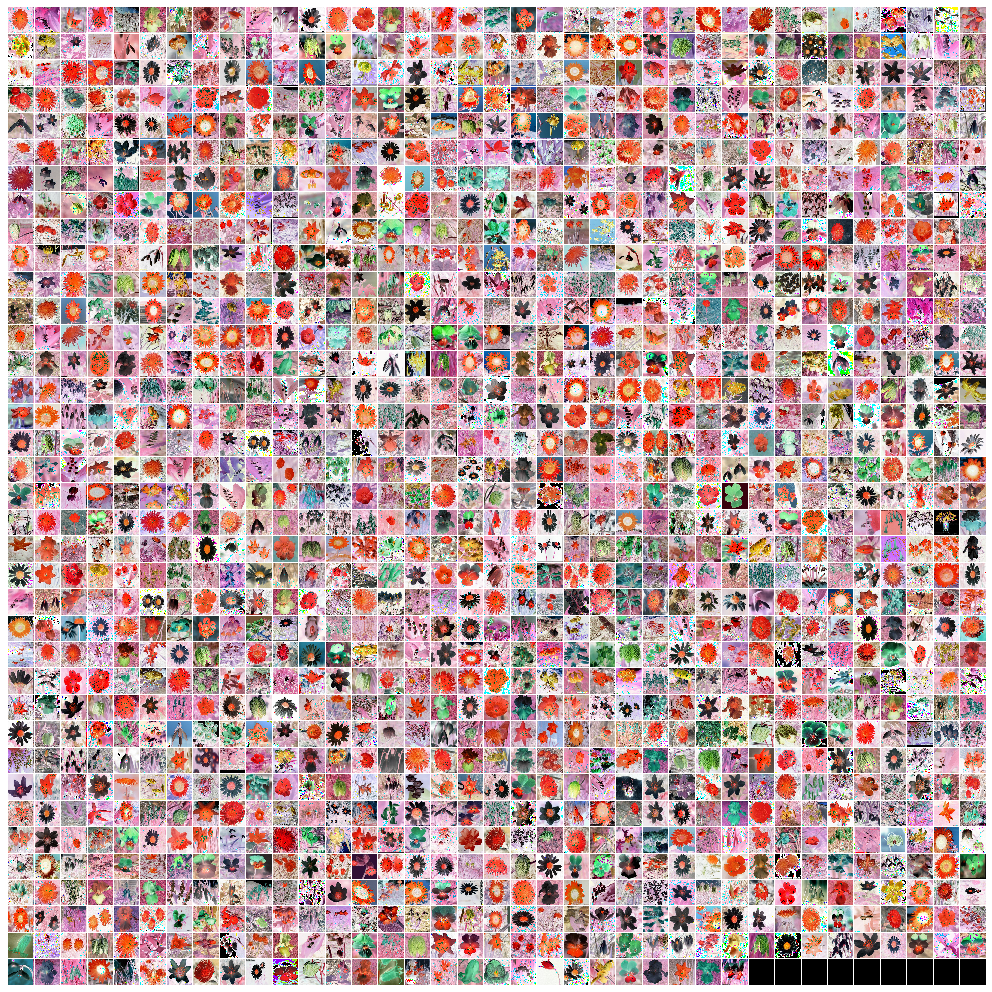

In [60]:
montage(X[..., ::-1], (18, 18))

In [0]:
random_img = X[100, ...] #take the 100th image from the dataset
weight_filter = np.random.randn(5, 5, 3) #make random weights
output_feature_map = np.zeros([random_img.shape[0], random_img.shape[1]]) #create empty feature map

In [0]:
for i in range(5, random_img.shape[0]-5): #loop through rows
  for j in range(5, random_img.shape[0]-5): #loop through columns
    output_feature_map[i, j] = np.sum(weight_filter * random_img[i:i+5, j:j+5, :]) #weighted sum

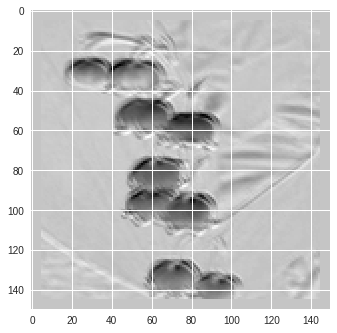

In [63]:
plt.imshow(output_feature_map, cmap='gray')

In [0]:
output_feature_map = np.int32(output_feature_map > 0) * output_feature_map

In [65]:
print(output_feature_map.shape)

(150, 150)


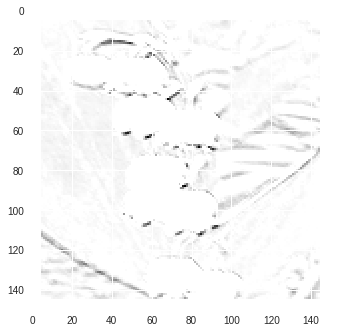

In [66]:
plt.imshow(np.float32(output_feature_map))

In [0]:
X -= np.mean(X,0) #center each pixel by 
X /= np.std(X,0) #squash each pixel between -1 and 1

(array([8.500000e+02, 5.138000e+03, 1.051000e+04, 2.470000e+04,
        4.701500e+04, 7.110400e+04, 9.616700e+04, 1.266000e+05,
        1.608390e+05, 2.050910e+05, 2.683930e+05, 3.692020e+05,
        5.376320e+05, 7.226730e+05, 9.138750e+05, 1.098722e+06,
        1.186532e+06, 1.318372e+06, 1.722914e+06, 2.431450e+06,
        3.097677e+06, 2.965134e+06, 2.831199e+06, 2.743265e+06,
        2.668450e+06, 2.606131e+06, 2.552065e+06, 2.489234e+06,
        2.438283e+06, 2.380034e+06, 2.328335e+06, 2.275096e+06,
        2.218972e+06, 2.155293e+06, 2.095453e+06, 2.036057e+06,
        1.980990e+06, 1.921063e+06, 1.863690e+06, 1.814762e+06,
        1.759509e+06, 1.701701e+06, 1.643069e+06, 1.590107e+06,
        1.539042e+06, 1.487755e+06, 1.440069e+06, 1.396616e+06,
        1.358024e+06, 1.313815e+06, 1.274264e+06, 1.231567e+06,
        1.187719e+06, 1.147279e+06, 1.104267e+06, 1.068368e+06,
        1.030877e+06, 9.920150e+05, 9.207130e+05, 8.449070e+05,
        7.751060e+05, 6.923400e+05, 6.37

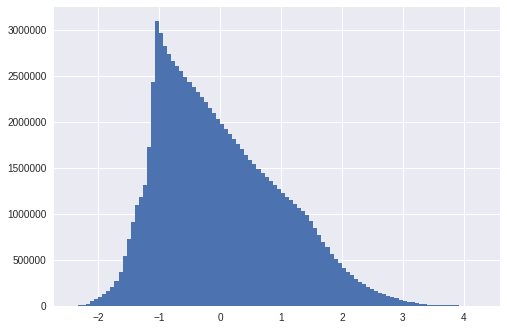

In [68]:
plt.hist(X.flatten(), bins = 100) #view histogram of normalized data

In [0]:
tf.reset_default_graph() #reset the tensor flow graph

In [0]:
#augment images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright() #randomly flip some images left to right
img_aug.add_random_rotation(max_angle=33.) #randomly rotate images up to 33 degrees
img_aug.add_random_crop((150, 150), padding=15) #randomly crop a 120 x 120 frame out of images

In [0]:
#create a layer to view data space in tensorboard
emb = tf.Variable(X[::10, ...], name='input_flower_images')

In [0]:
# tflearn.org/layers/conv/#convolution-2d for help

#create input layer that takes in images and augments them as well
in_layer = input_data(shape=[None, 150, 150, 3], data_augmentation=img_aug)

#have 64, 7x7 filters slide over the input images
conv1 = conv_2d(in_layer, 64, 7, activation='linear', name='c1')

#normalize conv1 layer feature maps
batch_norm1 = bn(conv1, name='bn1')

#perform relu activation function
relu1 = relu(batch_norm1)

#max pooling 
pool1 = max_pool_2d(relu1, 3, 2)

#second conv layer with 128, 3x3 filters
conv2 = conv_2d(pool1, 128, 3, activation='linear', name='c2')

#second normalization layer
batch_norm2 = bn(conv2, name='bn2')

#second relu layer
relu2 = relu(batch_norm2)

#max pooling layer 2
pool2 = max_pool_2d(relu2, 3, 2)

#third conv layer with 128, 3x3 filters
conv3 = conv_2d(pool2, 256, 3, activation='linear', name='c3')

#third normalization layer
batch_norm3 = bn(conv3, name='bn3')

#third relu layer
relu3 = relu(batch_norm3)

#take the average of each of the 256 feature maps ----- num_images x 1 x 1 x 256
gap = global_avg_pool(relu3)

#output layer ----- softmax turns output values into probabilities
out_layer = fully_connected(gap, 17, activation='softmax', name='fc')

In [0]:
#describe how to optimize the network's weights
network = regression(out_layer, optimizer='adam',
                     loss='categorical_crossentropy', learning_rate=.001)

In [0]:
#build the network based on the description above
model = tflearn.DNN(network, tensorboard_verbose=2)

In [75]:
#name for tensorboard 
tensorboard_name = 'flowers_cnn'
viz_embedding(emb, X[::10, ...], np.argmax(Y[::10, ...], 1), [150, 150, 3])

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImageAugmentation' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [76]:
#start tensorboard
install_tensorboard_dep()
start_tensorboard()

http://01ea3379.ngrok.io


In [77]:
if Train:
  model.fit(X, Y, n_epoch=50, shuffle=True, validation_set=0.1,
            show_metric=True, batch_size=50, run_id='OxfordFlowers_CNN')
  model.save('flowers_CNN')

Training Step: 119  | total loss: 1.72002 | time: 12.353s
| Adam | epoch: 005 | loss: 1.72002 - acc: 0.4554 -- iter: 0950/1224


KeyboardInterrupt: ignored

In [0]:
sess = tf.Session()  # tensorflow session
sess.run(tf.global_variables_initializer())

In [0]:
def load_layer(layer_name, data):
  '''A function to retrieve feature maps with name layer_name
     from the model given input data. '''
  layer = sess.run(layer_name, {in_layer:data[None, ...]})
  print(layer.shape)
  return layer

In [0]:
def view_feature_map(layer):
  n, h, w, c = layer.shape
  layer = layer.transpose((0, 3, 1, 2)).reshape([n*c, h, w])
  montage(layer, cmap='gray')

In [0]:
# choose 1 random number between 0 and the number of examples in the dataset
random_index = np.random.randint(0, X.shape[0], 1)[0]

# take out the image at that spot to use 
new_img = X[random_index, ...]

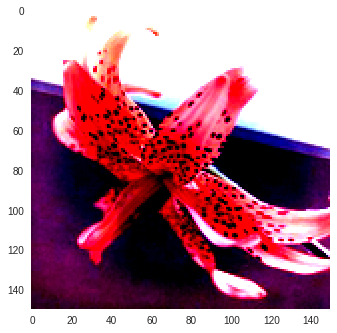

In [101]:
# view the original image
img_show = bytescale(new_img, 0, 1) # make values in new_img go between 0 and 1 to show it in matplotlib
plt.imshow(img_show)  # tell it what to show
plt.grid(False)  # get rid of the gridlines since this is not a graph
plt.show()  # show the image

In [0]:
# view the first conv layer's feature maps --- 64 different views of the image to help decide what it is
view_feature_map(load_layer(conv1, new_img))

# view results of the normalization layer
view_feature_map(load_layer(batch_norm1, new_img))

# view results of the rectified linear layer
view_feature_map(load_layer(relu1, new_img))

# view results of the pooling layer
view_feature_map(load_layer(pool1, new_img))

In [0]:
#view results of conv2, there are more images here because it has more convolution
view_feature_map(load_layer(conv2, new_img))

#view normalization layer 2, these images are more darkly shaded because it is making the darks darker
view_feature_map(load_layer(batch_norm2, new_img))

#view results of 2nd rectified linear layer, these images are more black because it is making all negative color channels equal to zero
view_feature_map(load_layer(relu2, new_img))

#view results of 2nd pooling layer, these images are more pixelated because it simplified the images to look at them more clearly
view_feature_map(load_layer(pool2, new_img))

(1, 38, 38, 256)


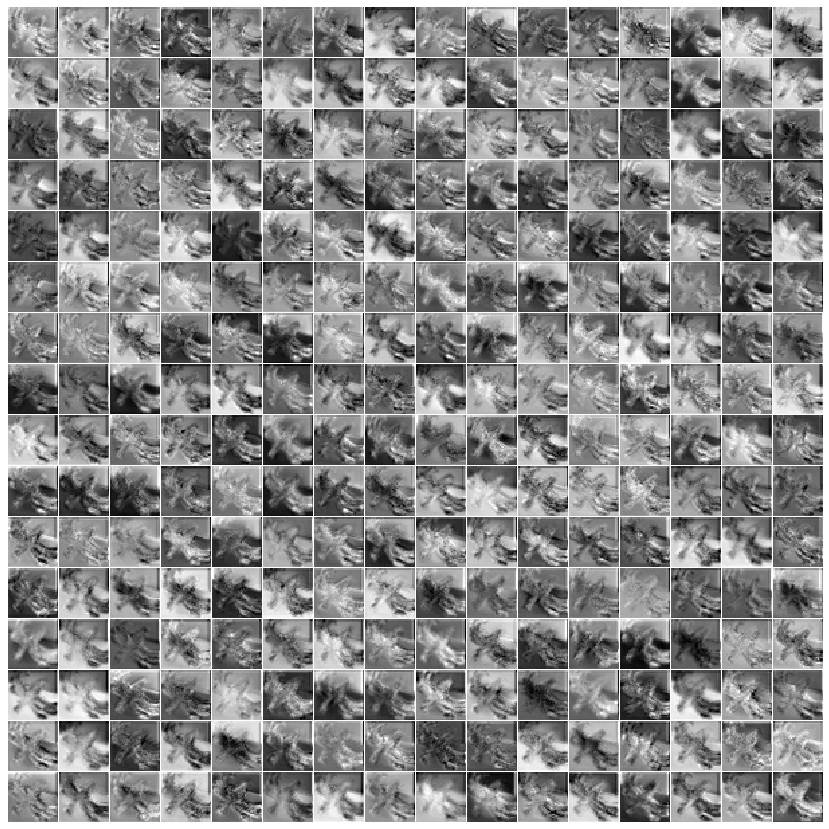

(1, 38, 38, 256)


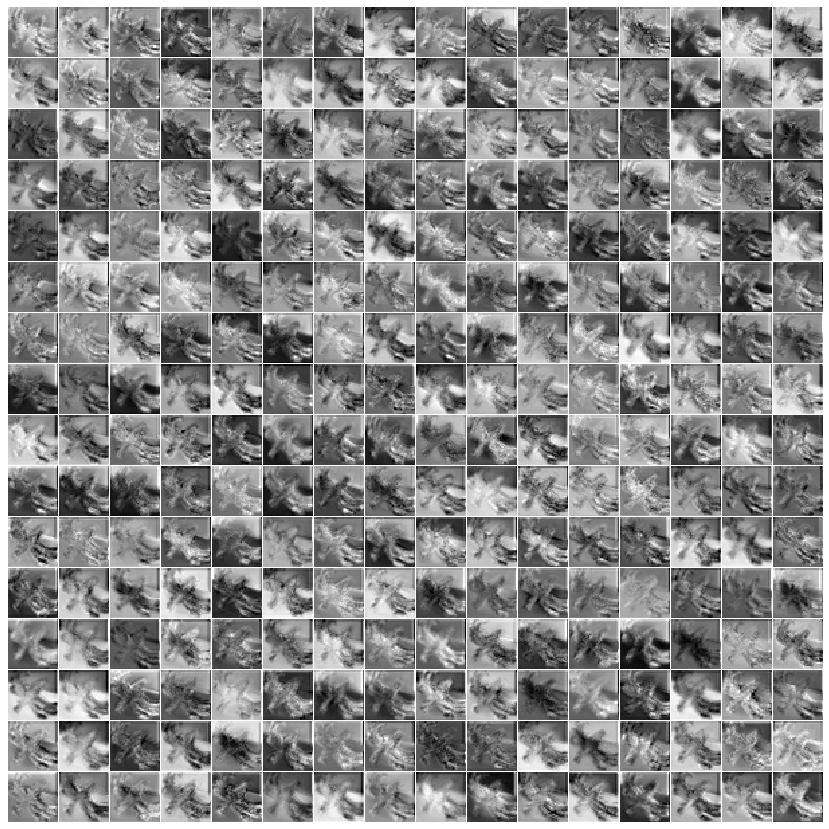

(1, 38, 38, 256)


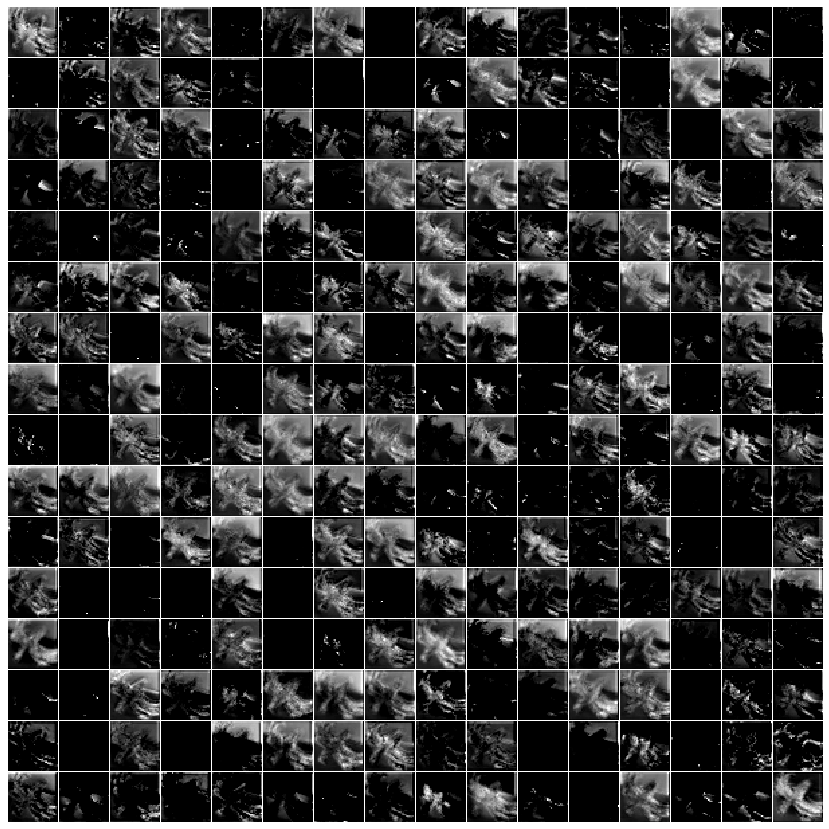

In [125]:
#view results of conv3, there are even more images here because it has even more convolution
view_feature_map(load_layer(conv3, new_img))

#view normalization layer 3, these look similar because it is normalizing the data
view_feature_map(load_layer(batch_norm3, new_img))

#view results of 3rd rectified linear layer, these are darker because it set negative valued pixels to 0
view_feature_map(load_layer(relu3, new_img))